# INDRA Data Statistics
This notebook is intended to provide an overview over the following characteristics of the dataset:
1. Bar plot with types of relations (distribution on number of triples per relation type)
2. Number of triples WITH evidence (all of them are supposed to have?)
3. Number of triples WITH annotations per fine-tuning task in our “benchmark”
4. Class distribution per annotation type
5. Average token length per annotation and its length distribution (plot distribution)
6. Number of triples with MULTIPLE evidences (%) among the annotated ones

## Options for reading large json files
The regular json package just loads the entire file into memory. Ideally, we would want to avoid that, given that we're
dealing with large json files. Possible candidate packages to use are:
* ijson: https://pypi.org/project/ijson/
* json-streamer: https://github.com/kashifrazzaqui/json-streamer
* bigjson: https://github.com/henu/bigjson
* pybel

--> just use pybel for now, it's much easier anyways

## Imports and constants

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pybel
from tqdm import tqdm
from collections import Counter

from transformers import AutoTokenizer, PreTrainedTokenizerFast
from tokenizers import BertWordPieceTokenizer
from pybel.constants import (
    ANNOTATIONS,
    EVIDENCE,
    RELATION,
    CITATION,
    INCREASES,
    DIRECTLY_INCREASES,
    DECREASES,
    DIRECTLY_DECREASES,
    REGULATES,
    BINDS,
    CORRELATION,
    NO_CORRELATION,
    NEGATIVE_CORRELATION,
    POSITIVE_CORRELATION,
    ASSOCIATION,
    PART_OF,
)

DIRECT_RELATIONS = {
    DIRECTLY_INCREASES,
    DIRECTLY_DECREASES,
    BINDS,
}

INDIRECT_RELATIONS = {
    REGULATES,
    CORRELATION,
    DECREASES,
    INCREASES,
    NO_CORRELATION,
    NEGATIVE_CORRELATION,
    POSITIVE_CORRELATION,
    ASSOCIATION,
    PART_OF,
}

UP_RELATIONS = {
    INCREASES,
    POSITIVE_CORRELATION,
    DIRECTLY_INCREASES
}

DOWN_RELATIONS = {
    DECREASES,
    NEGATIVE_CORRELATION,
    DIRECTLY_DECREASES
}

DUMMY_EXAMPLE_INDRA = os.path.join("../data/raw/", 'statements_2021-01-30-17-21-54.json')
INPUT_DIR = os.path.join("../data/", 'input/')
PRETRAINING_DIR = os.path.join(INPUT_DIR, 'pretraining/')
VOCAB_FILE = os.path.join("../data/misc/", 'biobert_vocab.txt')

## Loading the Data (batch wise)

In [2]:
# Use pybel for processing the json
# indra_kg = pybel.io.indra.from_indra_statements_json_file(DUMMY_EXAMPLE_INDRA)
# indra_kg.summarize()

batch_size = 10000000

with open(INDRA_RAW_JSON) as file:
    for line_number, line in tqdm(
        enumerate(file),
        desc='parsing file',
        total=35150093,  # TODO: hard coded
    ):
        try:
            line_dict = json.loads(line)
        except:
            errors.append(line_number)

        lines.append(line_dict)

logger.info(f'{len(errors)} statements with errors from {len(lines)} statements')

# round down the number of chunks
chunks = len(lines)//batch_size

# create a list for the partial KGs that should be merged in the end
partial_indra_kgs = []
for i in range(chunks):
    # process the lines chunk wise
    partial_indra_kgs.append(pybel.io.indra.from_indra_statements_json(
        lines[i*batch_size:(i+1)*batch_size]
    ))
# process last chunk differently
partial_indra_kgs.append(pybel.io.indra.from_indra_statements_json(
    lines[(i+1)*batch_size:]
))
indra_kg = pybel.union(partial_indra_kgs)

del partial_indra_kgs

indra_kg.summarize()

INFO: [2021-04-13 12:09:03] indra.assemblers.pybel.assembler - Skipping modification of type modification on agent EP300(mods: (modification))
INFO: [2021-04-13 12:09:03] indra.assemblers.pybel.assembler - Skipping modification of type modification on agent EP300(mods: (modification))
INFO: [2021-04-13 12:09:03] indra.assemblers.pybel.assembler - Skipping modification of type modification on agent EP300(mods: (modification))
INFO: [2021-04-13 12:09:03] indra.assemblers.pybel.assembler - Skipping modification of type modification on agent ERBB2(mods: (modification))
INFO: [2021-04-13 12:09:04] indra.assemblers.pybel.assembler - Skipping modification of type modification on agent BAX(mods: (modification))
INFO: [2021-04-13 12:09:04] indra.assemblers.pybel.assembler - Skipping modification of type sumoylation on agent AKT1(mods: (sumoylation, K, 276))
INFO: [2021-04-13 12:09:04] indra.assemblers.pybel.assembler - Skipping modification of type sumoylation on agent SMAD4(mods: (sumoylation,

---------------------  ------------------------------------
Name                   indra
Version                c3c04b46-c84a-48fe-bc94-289341553665
Author                 INDRA
Number of Nodes        2939
Number of Namespaces   11
Number of Edges        20034
Number of Annotations  31
Number of Citations    10003
Number of Authors      0
Network Density        2.32E-03
Number of Components   13
Number of Warnings     0
---------------------  ------------------------------------

Type (4)             Count  Example
-----------------  -------  ----------------------------------------------------------------------------
Protein               1468  p(HGNC:3821 ! FOXO3, pmod(go:0006468 ! "protein phosphorylation", Ser, 318))
Complex               1071  complex(p(HGNC:11642 ! ZEB1), p(HGNC:11998 ! TP53))
Abundance              318  a(CHEBI:51079 ! GS26575)
BiologicalProcess       82  bp(GO:"GO:0045444" ! "fat cell differentiation")

Namespace (11)      Count  Example
----------------  -----

## Put everything in a dataframe

In [3]:
# Dump the entire data (as long as there is an evidence)
triple_text_pairs = []

# Context annotations (OLD)
"""context_annotations = {'organ': ['MeSHAnatomy'], 
                       'species': ['TAX_ID'], 
                       'disease': ['MeSHDisease', 'Disease'],
                       'cell_type': ['Cell'],
                       'cell_line': ['CellLine'],
                       'location': ['CellStructure']
                      }
"""
# Updated context annotations 
context_annotations = {'organ': ['organ'], 
                       'species': ['species'], 
                       'disease': ['disease'],
                       'cell_type': ['cell_type'],
                       'cell_line': ['cell_line'],
                       'location': ['location']
                      }

# Iterate through the graph and infer a subgraph with edges that contain the annotation of interest
for u, v, data in indra_kg.edges(data=True):
    entry_dict = {
        'source': u,
        'relation': data[RELATION],
        'target': v,
        'evidence': data[EVIDENCE] if EVIDENCE in data else None,
        'pmid': data[CITATION] if CITATION in data else None,
    }
    
    # Look for annotations
    if ANNOTATIONS in data:
        # print(data[ANNOTATIONS].keys())
        
        # Go through every annotation type 
        for context_type in context_annotations.keys():
            # Handle diseases differently as there are two annotation fields 
            # Not needed anymore
"""            if context_type == 'disease':
                if context_annotations[context_type][0] in data[ANNOTATIONS]: 
                    entry_dict[context_type] = data[ANNOTATIONS][context_annotations[context_type][0]]
                elif context_annotations[context_type][1] in data[ANNOTATIONS]: 
                    entry_dict[context_type] = data[ANNOTATIONS][context_annotations[context_type][1]]
                else:
                    entry_dict[context_type] = None

            else: """
            entry_dict[context_type] = data[ANNOTATIONS][context_annotations[context_type][0]] \
                                       if context_annotations[context_type][0] in data[ANNOTATIONS] \
                                       else None
        entry_dict['stmt_hash'] = data[ANNOTATIONS]['stmt_hash'] if 'stmt_hash' in data[ANNOTATIONS] else None
    # If there are none, just add None for all class types
    else: 
        for context_type in context_annotations.keys():
            entry_dict[context_type] = None
            entry_dict['stmt_hash'] = None
            
    triple_text_pairs.append(entry_dict)
                
all_triple_text_pairs = pd.DataFrame(triple_text_pairs)

all_triple_text_pairs.head(n=50)
all_triple_text_pairs.to_csv(os.path.join(INPUT_DIR, 'all_triples.tsv'), sep='\t', index=False)

Read the data (so that it doesn't need to be generated in each run again)

In [3]:
all_triple_text_pairs = pd.read_csv(os.path.join(INPUT_DIR, 'all_triples.tsv'), sep='\t', index_col=None)

# Print the total number of triples 
print(f'Total number of triples: {len(all_triple_text_pairs)}')

Total number of triples: 13783728


## 1. Bar plot with types of relations

Number of unique relations 4


Text(0, 0.5, 'Frequency')

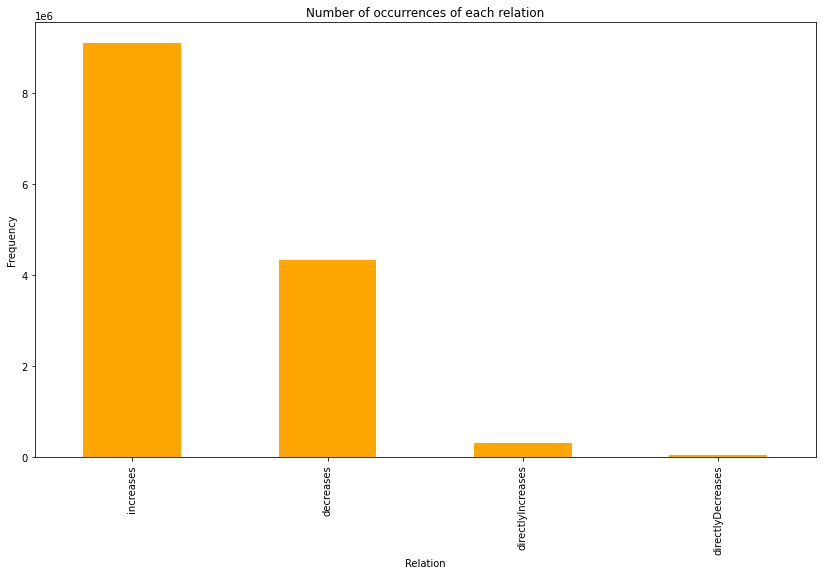

In [4]:
# Get the number of unique relations
print(f'Number of unique relations {len(np.unique(all_triple_text_pairs["relation"]))}')
# Print the frequencies of the different relations in a barchart, only plot the 20 most frequent ones
ax = all_triple_text_pairs['relation'].value_counts().sort_values(ascending=False)[:20].plot(kind='bar',
                                       figsize=(14,8),
                                       color='orange',
                                       title='Number of occurrences of each relation')
ax.set_xlabel('Relation')
ax.set_ylabel('Frequency')

## 2. Number of triples WITH evidence

In [6]:
# Filter by those entries that have evidence (and that don't have 'No evidence text.')
entries_with_evidence = all_triple_text_pairs[all_triple_text_pairs['evidence'] is not None and
                                           all_triple_text_pairs['evidence'] != 'No evidence text.']
entries_with_evidence = entries_with_evidence[entries_with_evidence['evidence'].apply(lambda x: isinstance(x,str))]

# Print percentage
print(f'{len(entries_with_evidence)/len(all_triple_text_pairs) * 100} % ({len(entries_with_evidence)} many) \
of the triples have text evidence')

82.85913946291305 % (16600 many) of the triples have text evidence


## 3. Number of triples WITH annotations (and evidence) per fine-tuning task in our “benchmark” + 

## 4. Class distribution per annotation type

Before any kind of minority class filtering: 

7.062992912049516 % (1415 many) of the triples have any type of annotation 

Number of entries with a(n) organ annotation BEFORE filtering: 294
Number of entries with a(n) species annotation BEFORE filtering: 969
Number of entries with a(n) disease annotation BEFORE filtering: 449
Number of entries with a(n) cell_type annotation BEFORE filtering: 449
Number of entries with a(n) cell_line annotation BEFORE filtering: 449
Number of entries with a(n) location annotation BEFORE filtering: 449


Number of entries with direct/indirect relations: 3461, 13139
Number of entries with up/down relations: 10252, 6348


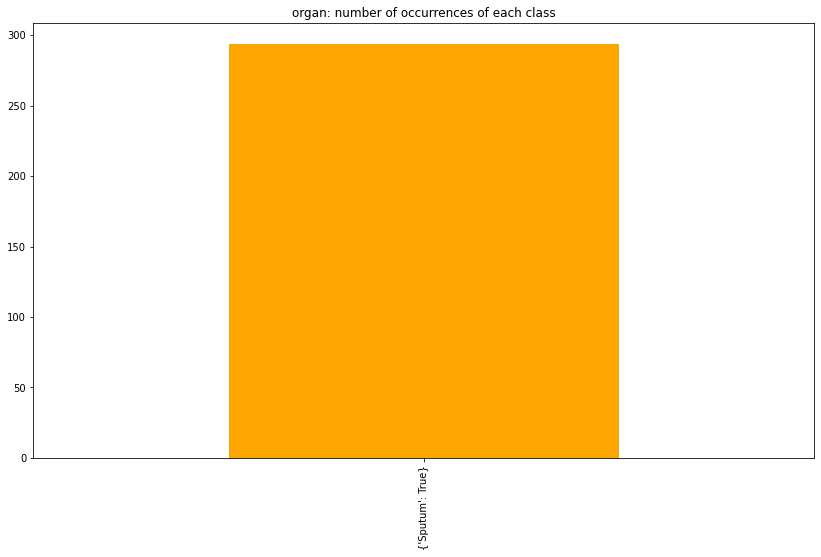

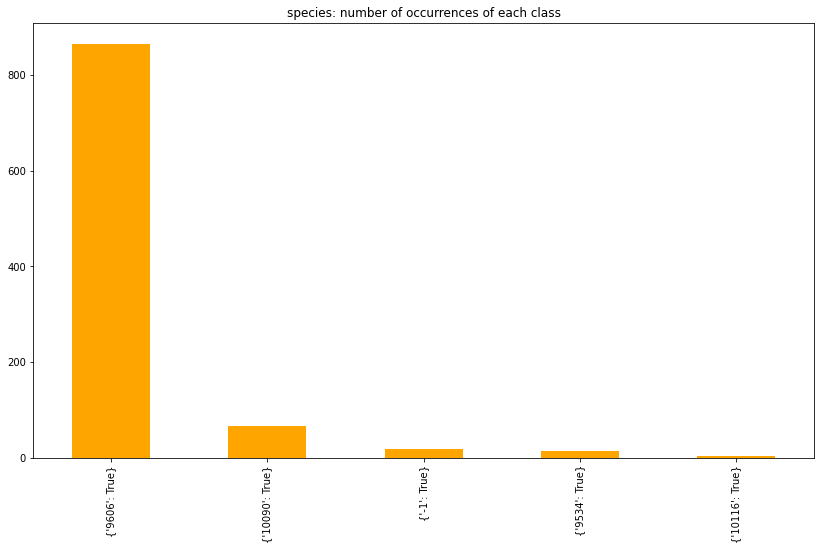

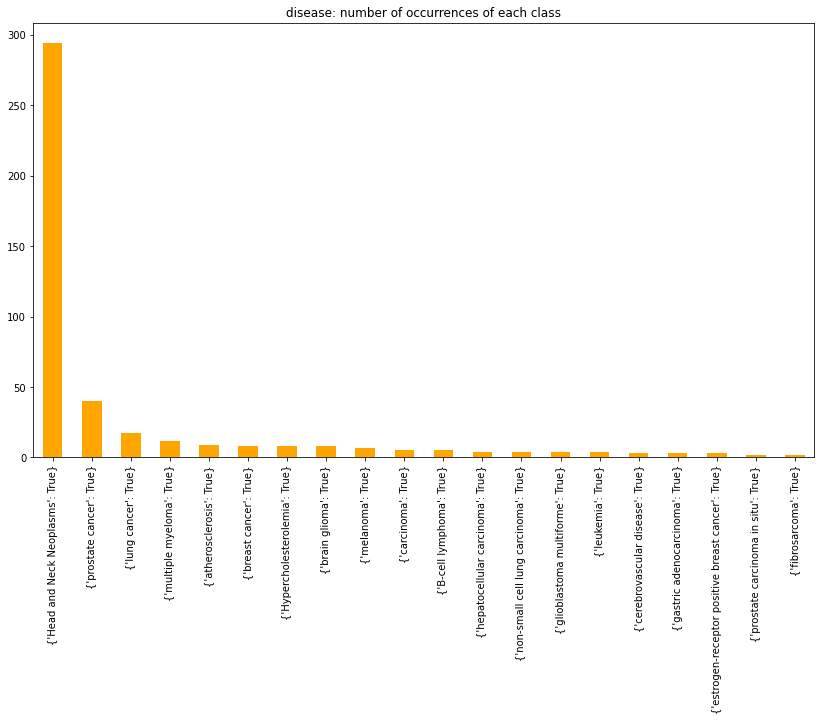

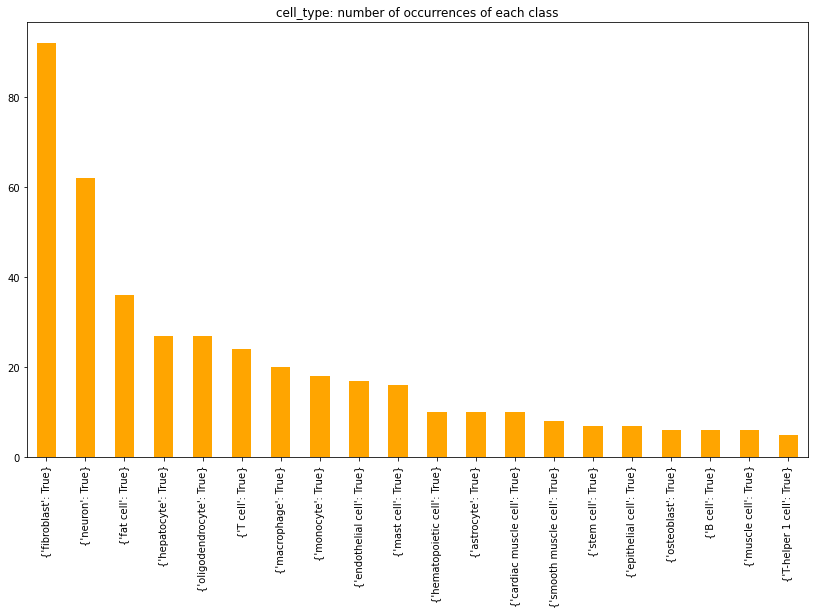

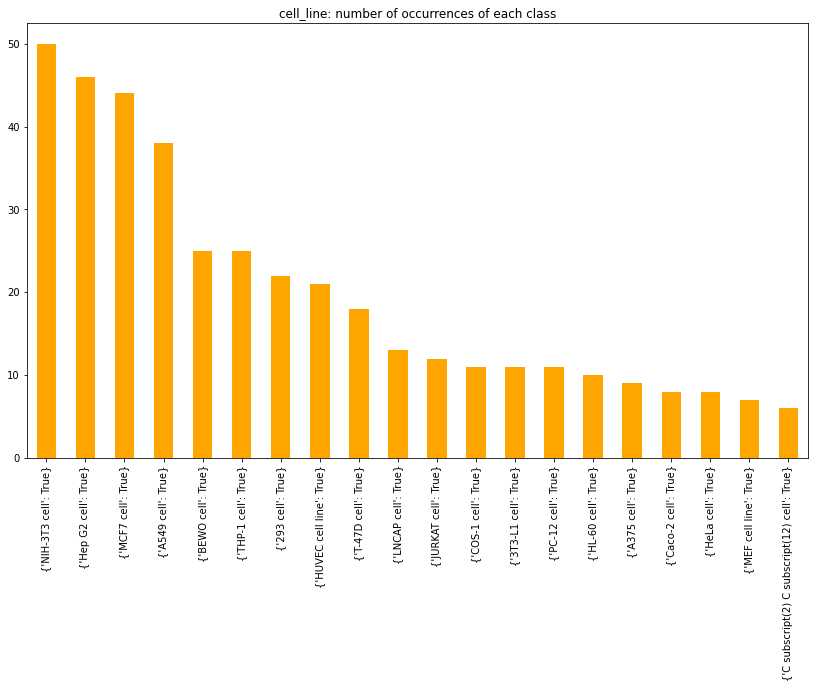

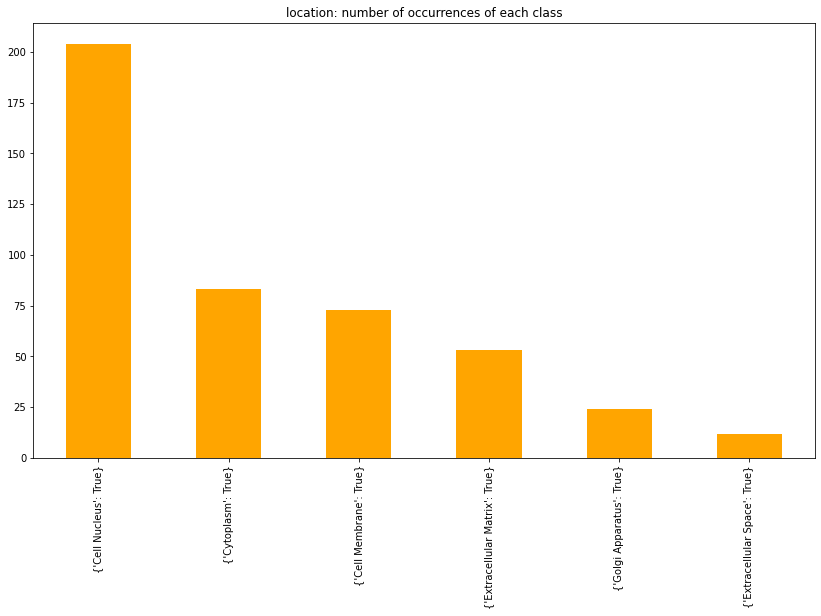

In [7]:
# Filter by those entries that have any type of annotation
entries_with_annotations = entries_with_evidence[entries_with_evidence.filter(
    ['cell_type', 'cell_line', 'species', 'disease', 'organ', 'location']).notna().any(axis=1)]

# Print percentage: entries with annotations (and evidence) from all entities
print(f'{len(entries_with_annotations)/len(all_triple_text_pairs) * 100} % ({len(entries_with_annotations)} many) \
of the triples have any type of annotation \n')

# For each annotation type (species etc.) check how many entries there are
for annotation_type in context_annotations: 
    print(f'Number of entries with a(n) {annotation_type} annotation BEFORE filtering: \
{len(entries_with_evidence[entries_with_evidence[annotation_type].notna()])}')
    
    # Bar plot for that class
    entries_with_evidence[entries_with_evidence[annotation_type].notna()][annotation_type].value_counts(). \
    sort_values(ascending=False)[:20].plot(kind='bar',
                                           figsize=(14,8),
                                           color='orange',
                                           title=f'{annotation_type}: number of occurrences of each class')
    plt.show()
    
print('\n')


# Check number of direct/indirect relations
entries_direct = entries_with_evidence[entries_with_evidence["relation"].isin(DIRECT_RELATIONS)]
entries_indirect = entries_with_evidence[entries_with_evidence["relation"].isin(INDIRECT_RELATIONS)]

# Check number of up/down relations
entries_up = entries_with_evidence[entries_with_evidence["relation"].isin(UP_RELATIONS)]
entries_down = entries_with_evidence[entries_with_evidence["relation"].isin(DOWN_RELATIONS)]

print(f'Number of entries with direct/indirect relations: {len(entries_direct)}, {len(entries_indirect)}')
print(f'Number of entries with up/down relations: {len(entries_up)}, {len(entries_down)}')

After filtering:

<ipython-input-8-8c84f3b0a175>:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  class_specific_dfs[annotation_type] = entries_with_annotations[


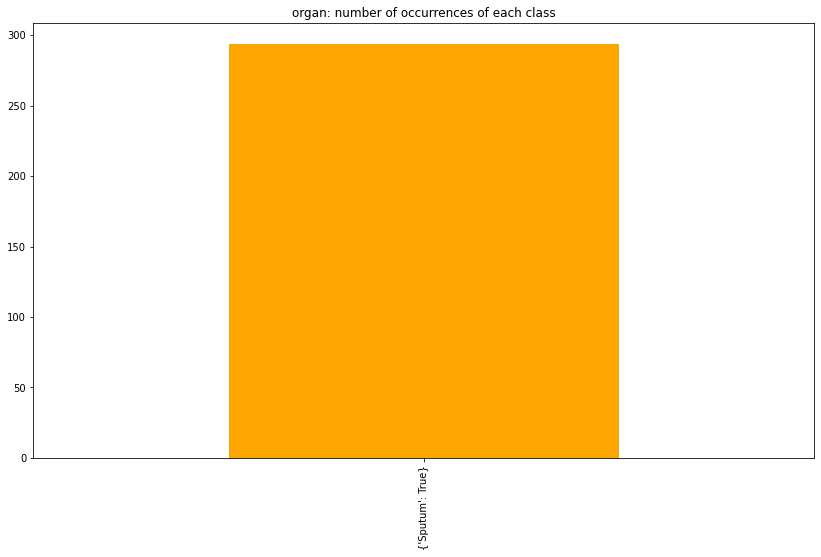

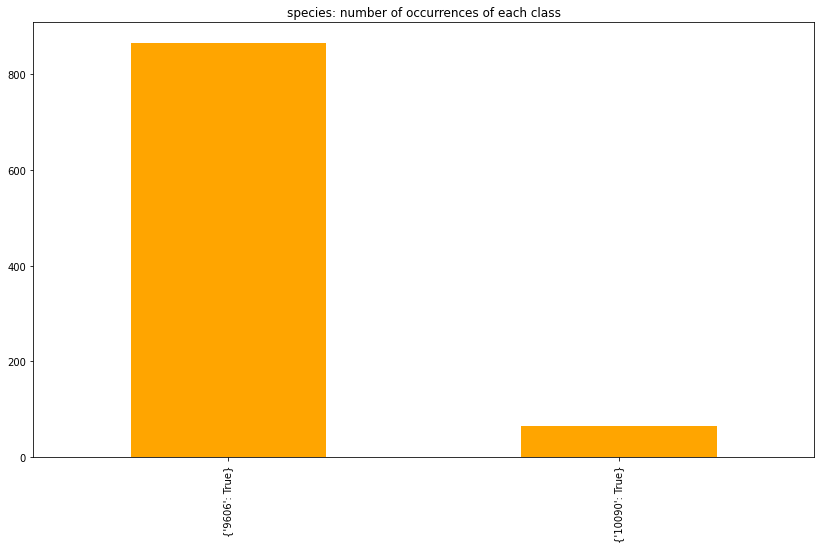

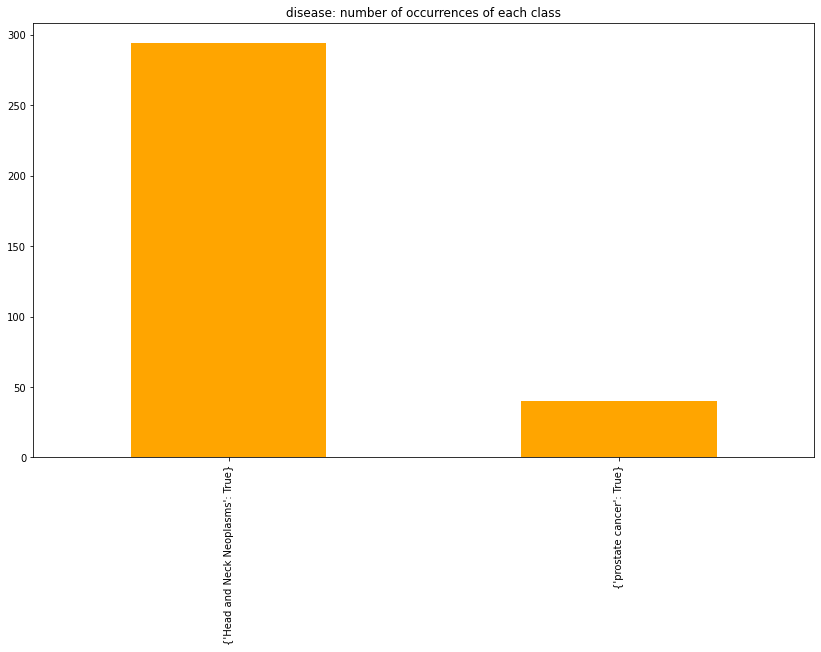

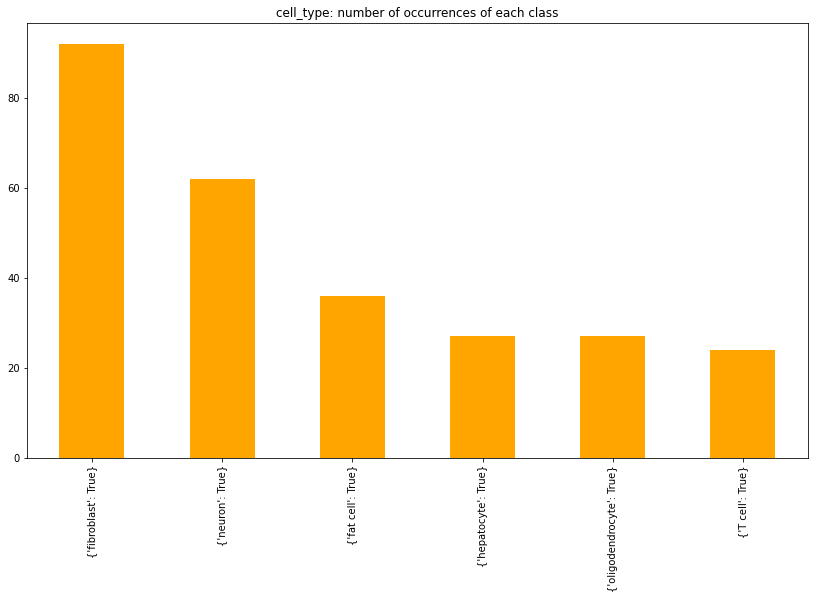

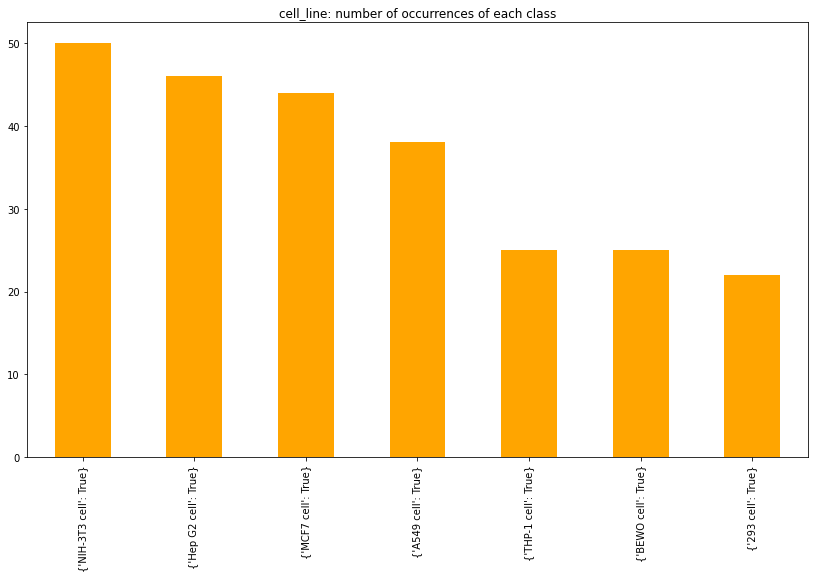

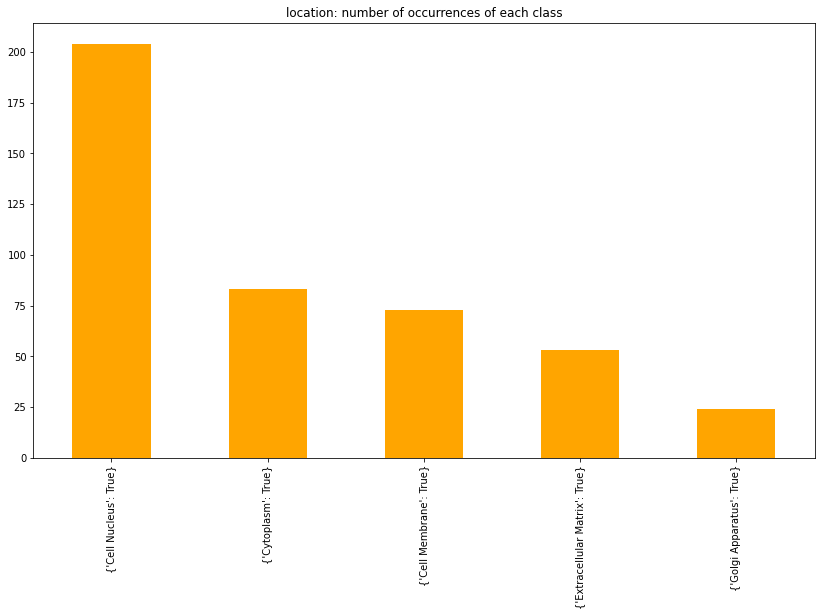

Number of entries with a(n) organ annotation AFTER filtering: 294
Number of entries with a(n) species annotation AFTER filtering: 931
Number of entries with a(n) disease annotation AFTER filtering: 334
Number of entries with a(n) cell_type annotation AFTER filtering: 268
Number of entries with a(n) cell_line annotation AFTER filtering: 250
Number of entries with a(n) location annotation AFTER filtering: 437


In [8]:
# Create class-specific dataframes 
class_specific_dfs = {}

# Filter out minority classes
for annotation_type in context_annotations.keys():
    label_counts = entries_with_annotations[annotation_type].value_counts().to_dict()
    
    # Labels are removed if they contain less than 5% of the (non-null) entries
    percentage = 0.05
    cutoff = int(entries_with_annotations[
        entries_with_annotations[annotation_type].notnull()].shape[0] * percentage)
    
    # Remove labels based on class count 
    labels_to_remove = {
        label: count
        for label, count in label_counts.items()
        if count < cutoff
    }
    
    # Get create class specific dictionaries by filtering out null values and the labels to remove
    class_specific_dfs[annotation_type] = entries_with_annotations[
        entries_with_annotations[annotation_type].notnull()][
        ~entries_with_annotations[annotation_type].isin(list(labels_to_remove.keys()))]
    
    # Bar plot for that class
    class_specific_dfs[annotation_type][annotation_type].value_counts(). \
    sort_values(ascending=False)[:20].plot(kind='bar',
                                           figsize=(14,8),
                                           color='orange',
                                           title=f'{annotation_type}: number of occurrences of each class')
    plt.show()
    
# Print the statistics
for annotation_type in context_annotations: 
    print(f'Number of entries with a(n) {annotation_type} annotation AFTER filtering: \
{len(class_specific_dfs[annotation_type])}')

## 5. Average token length per annotation and its length distribution (plot distribution)

In [9]:
# Load the BioBERT tokenizer to be able to count the tokens later on
biobert_tokenizer = AutoTokenizer.from_pretrained('dmis-lab/biobert-v1.1')

biobert_tokenizer.tokenize(entries_with_evidence["evidence"][100])

['Mu',
 '##tations',
 'in',
 'the',
 'T',
 '##P',
 '##53',
 'gene',
 'promote',
 'un',
 '##re',
 '##gu',
 '##lated',
 'cell',
 'growth',
 'through',
 'the',
 'in',
 '##act',
 '##ivation',
 'of',
 'downstream',
 'effect',
 '##ors',
 'of',
 'the',
 'p',
 '##53',
 'pathway',
 '.']

Tokenize the text and count the token length per evidence

In [10]:
token_counts = []

for i in entries_with_evidence["evidence"]: 
    try: 
        token_counts.append(len(biobert_tokenizer.tokenize(i)))
    except: 
        print(f'Failed to tokenize the following sequence: {i}')

Token indices sequence length is longer than the specified maximum sequence length for this model (620 > 512). Running this sequence through the model will result in indexing errors


Plot the token length distribution

Text(0, 0.5, 'Frequency')

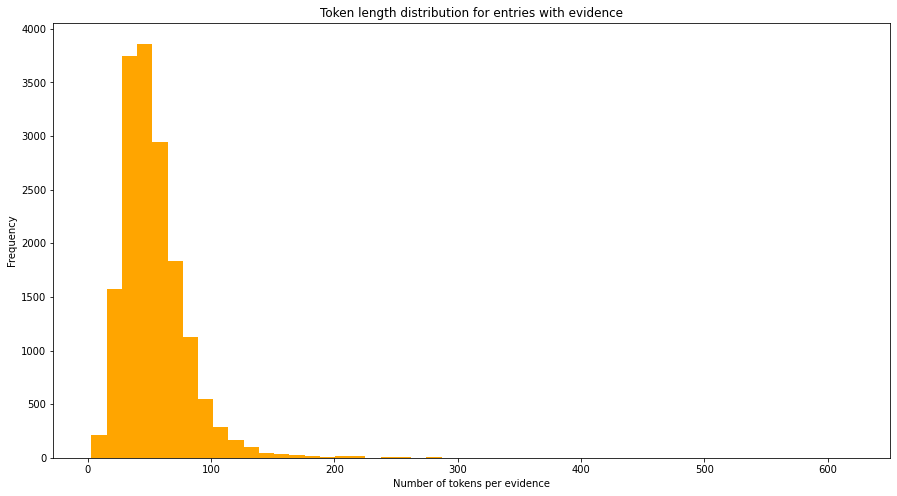

In [11]:
plt.figure(figsize=(15,8))
plt.hist(token_counts, bins=50, color='orange')
plt.title('Token length distribution for entries with evidence')
plt.xlabel('Number of tokens per evidence')
plt.ylabel('Frequency')

## 6. Number of triples with MULTIPLE evidences (%) among the annotated ones

In [12]:
# Count the number of evidences per triple based on the statement hash
evidence_per_triple_counts = entries_with_evidence['stmt_hash'].value_counts()

print('Triples with most evidences')
print(evidence_per_triple_counts.sort_values(ascending=False).head(n=20))
print('\n')

# Get the ones that have only one triple 
one_evidence_triples = len([i for i in evidence_per_triple_counts.values if i == 1])
two_evidence_triples = len([i for i in evidence_per_triple_counts.values if i == 2])

print(f'{one_evidence_triples} many triples have only one text evidence.')
print(f'{len(evidence_per_triple_counts) - one_evidence_triples} \
({(len(evidence_per_triple_counts) - one_evidence_triples)/len(evidence_per_triple_counts) * 100} %) \
many triples have at least two text evidences.')
print(f'{two_evidence_triples} many triples have two text evidences.')

Triples with most evidences
{22395531836265113: True}     159
{5824568218769678: True}      138
{-35357180905875939: True}    135
{-31185548029718339: True}    121
{-3533841422894277: True}     117
{17676853791266511: True}     113
{10871486261697855: True}     112
{28715851778559714: True}      96
{35849708729068564: True}      79
{12274858344847581: True}      75
{-28975859915709101: True}     73
{-20560506955386703: True}     70
{-33631034232650571: True}     69
{-34193242047172973: True}     66
{-32375988341797140: True}     65
{3055119866521039: True}       61
{-12813874982973260: True}     60
{-24189126920331822: True}     60
{-35076257712553724: True}     58
{7399843842127385: True}       56
Name: stmt_hash, dtype: int64


694 many triples have only one text evidence.
3351 (82.84301606922126 %) many triples have at least two text evidences.
1689 many triples have two text evidences.


Distribution of number per evidences for those with multiple evidences (excluding those with one)

(array([2.779e+03, 2.640e+02, 1.030e+02, 5.700e+01, 3.300e+01, 2.300e+01,
        1.500e+01, 8.000e+00, 9.000e+00, 8.000e+00, 1.000e+01, 1.100e+01,
        5.000e+00, 0.000e+00, 3.000e+00, 1.000e+00, 1.000e+00, 3.000e+00,
        3.000e+00, 0.000e+00, 2.000e+00, 2.000e+00, 1.000e+00, 1.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([  2.  ,   5.14,   8.28,  11.42,  14.56,  17.7 ,  20.84,  23.98,
         27.12,  30.26,  33.4 ,  36.54,  39.68,  42.82,  45.96,  49.1 ,
         52.24,  55.38,  58.52,  61.66,  64.8 ,  67.94,  71.08,  74.22,
         77.36,  80.5 ,  83.64,  86.78,  89.92,  93.06,  96.2 ,  99.34,
        102.48, 105.62, 108.76, 111.9 , 115.04, 118.18, 121.32, 124.46,
        127.6 , 

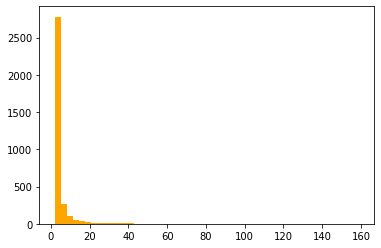

In [13]:
plt.hist([i for i in evidence_per_triple_counts.values if i > 1], bins=50, color='orange')

Close up on those with under 10 evidences (including those with only 1)

(array([ 694.,    0.,    0.,    0.,    0.,    0., 1689.,    0.,    0.,
           0.,    0.,    0.,  594.,    0.,    0.,    0.,    0.,    0.,
         325.,    0.,    0.,    0.,    0.,    0.,    0.,  171.,    0.,
           0.,    0.,    0.,    0.,  126.,    0.,    0.,    0.,    0.,
           0.,   83.,    0.,    0.,    0.,    0.,    0.,   55.,    0.,
           0.,    0.,    0.,    0.,   39.]),
 array([1.  , 1.16, 1.32, 1.48, 1.64, 1.8 , 1.96, 2.12, 2.28, 2.44, 2.6 ,
        2.76, 2.92, 3.08, 3.24, 3.4 , 3.56, 3.72, 3.88, 4.04, 4.2 , 4.36,
        4.52, 4.68, 4.84, 5.  , 5.16, 5.32, 5.48, 5.64, 5.8 , 5.96, 6.12,
        6.28, 6.44, 6.6 , 6.76, 6.92, 7.08, 7.24, 7.4 , 7.56, 7.72, 7.88,
        8.04, 8.2 , 8.36, 8.52, 8.68, 8.84, 9.  ]),
 <BarContainer object of 50 artists>)

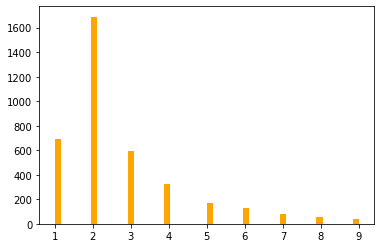

In [14]:
plt.hist([i for i in evidence_per_triple_counts.values if i < 10], bins=50, color='orange')


## The following statistics are generated for the pre-training data as of 03.05.2021 

In [3]:
all_triple_text_pairs = pd.read_csv(os.path.join(PRETRAINING_DIR, 'pretraining_triples.tsv'), sep='\t', index_col=None)

# Print the total number of triples 
print(f'Total number of triples: {len(all_triple_text_pairs)}')

Total number of triples: 13783728


## A) Token length distribution

In [10]:
# Load the BioBERT tokenizer to be able to count the tokens later on
biobert_tokenizer = AutoTokenizer.from_pretrained('dmis-lab/biobert-v1.1')

# Count the number of tokens in each sequence 
token_counts = []

with tqdm(total=all_triple_text_pairs.shape[0]) as pbar:    
    for i in all_triple_text_pairs["evidence"]: 
        try: 
            token_counts.append(len(biobert_tokenizer.tokenize(i)))
        except: 
            print(f'Failed to tokenize the following sequence: {i}')
        pbar.update(1)

100%|██████████| 13783728/13783728 [42:24<00:00, 5417.52it/s] 


Plot the token length distribution

Text(0, 0.5, 'Frequency')

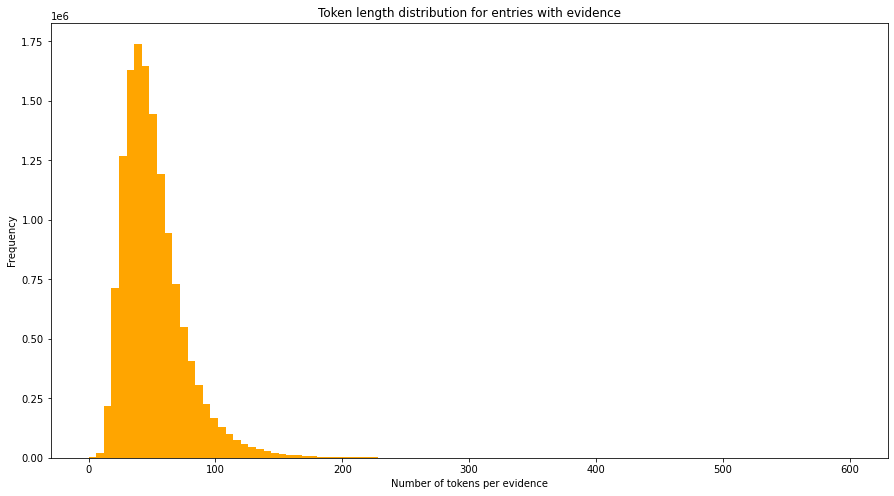

In [14]:
plt.figure(figsize=(15,8))
plt.hist(token_counts, bins=100, color='orange', range=(0,600))
plt.title('Token length distribution for entries with evidence')
plt.xlabel('Number of tokens per evidence')
plt.ylabel('Frequency')

## B) Most common words 

Based on a smaller 50K sample

In [17]:
# Load the BioBERT tokenizer as a fast tokenizer to be able to count the tokens later on
tokenizer = BertWordPieceTokenizer(VOCAB_FILE)

# Initialize the fast tokenizer 
biobert_tokenizer_fast = PreTrainedTokenizerFast(tokenizer_object=tokenizer)

# Take a smaller sample to avoid the script to crash 
sample_size = 50000
evidence_samples = all_triple_text_pairs["evidence"][:sample_size]

tokenized_samples = biobert_tokenizer_fast(list(evidence_samples))

In [18]:
all_tokens = []
for i in tqdm(range(sample_size)):
    all_tokens = all_tokens + tokenized_samples.tokens(i)

100%|██████████| 50000/50000 [16:22<00:00, 50.90it/s] 


In [19]:
# Counter for all tokens 
token_counts = Counter(all_tokens)

In [20]:
print(token_counts)

Counter({',': 77328, '-': 68018, 'of': 65203, 'in': 61351, '.': 58976, 'and': 58457, 'the': 58433, '[CLS]': 50000, '[SEP]': 50000, 'notch': 35534, '##1': 28650, '##s': 25449, 'a': 24221, 'to': 22767, ')': 21462, '##c': 21338, '(': 21300, 'c': 19875, 'e': 19713, 'that': 19392, '##n': 18235, 'p': 16753, 'by': 16626, 'cells': 15478, 'cell': 15294, 'expression': 15273, '##f': 15224, '##dh': 14534, '1': 13963, 'ca': 13221, 'signaling': 12965, '##d': 12785, '##p': 12553, '##eri': 11569, '##2': 11182, '##g': 11055, 'is': 10808, 's': 10290, '##b': 10183, '##pa': 10031, '##re': 9681, 'do': 9293, 't': 8956, '##mine': 8854, 'm': 8803, 'with': 8471, 'i': 7817, 'activation': 7551, '##l': 7522, 'g': 7147, 'as': 7045, 'd': 7039, '##hibit': 6904, 'l': 6784, 'induced': 6780, 'ad': 6749, 'pro': 6631, 'h': 6622, '##3': 6464, '##t': 6246, '##r': 6208, 'differentiation': 6063, 'r': 6020, 'we': 5826, '##al': 5776, '##cam': 5715, 'v': 5673, '##in': 5542, 'or': 5532, '/': 5501, 'which': 5430, 'x': 5369, 'was'